In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [31]:
from tqdm import tqdm
import os
import argparse
import torch
import pickle
import numpy as np
from nnlib.nnlib import utils
from nnlib.nnlib.visualizations import savefig
from modules.bound_utils import estimate_fcmi_bound_classification
import methods

In [4]:
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt
from nnlib.nnlib.matplotlib_utils import set_default_configs
import seaborn
set_default_configs(plt, seaborn)

In [5]:
class NestedDict(dict):
    def __missing__(self, key):
        self[key] = type(self)()
        return self[key]

In [6]:
def plot_curve(ax, xs, means, stds, marker=None, label=None):
    means = np.array(means)
    stds = np.array(stds)
    ax.plot(xs, means, label=label, marker=marker)
    plt.fill_between(xs, means-stds, means+stds, alpha=0.2)
    return ax

In [7]:
def plot_over_n(results, ns, epoch):
    fig, ax = plt.subplots(figsize=(6, 4))

    fcmi_means = []
    fcmi_stds = []
    gap_means = []
    gap_stds = []

    for n in ns:
        fcmi_mean = np.nanmean([d['fcmi_bound'] for d in results[n][epoch]])
        fcmi_std = np.nanstd([d['fcmi_bound'] for d in results[n][epoch]])
        if np.isnan(fcmi_std):
            fcmi_std = 0.0
        gap_mean = np.nanmean([d['exp_gap'] for d in results[n][epoch]])
        gap_std = np.nanstd([d['exp_gap'] for d in results[n][epoch]])
        if np.isnan(gap_std):
            gap_std = 0.0
        fcmi_means.append(fcmi_mean)
        fcmi_stds.append(fcmi_std)
        gap_means.append(gap_mean)
        gap_stds.append(gap_std)

    plot_curve(ax, range(len(ns)), gap_means, gap_stds, label=f'generalization gap', marker='o')
    plot_curve(ax, range(len(ns)), fcmi_means, fcmi_stds, label=f'f-CMI bound', marker='x')
    ax.set_xlabel('n')
    ax.set_ylabel('Error')
    ax.set_xticks(range(len(ns)))
    ax.set_xticklabels(ns)
    ax.legend()
    fig.tight_layout()
    
    print(gap_means)
    print(fcmi_means)
    
    return fig, ax

In [8]:
def plot_over_epochs(results, n, epochs):
    fig, ax = plt.subplots(figsize=(6, 4))

    fcmi_means = []
    fcmi_stds = []
    gap_means = []
    gap_stds = []
    for epoch in epochs:
        fcmi_mean = np.nanmean([d['fcmi_bound'] for d in results[n][epoch]])
        fcmi_std = np.nanstd([d['fcmi_bound'] for d in results[n][epoch]])
        if np.isnan(fcmi_std):
            fcmi_std = 0.0
        gap_mean = np.nanmean([d['exp_gap'] for d in results[n][epoch]])
        gap_std = np.nanstd([d['exp_gap'] for d in results[n][epoch]])
        if np.isnan(gap_std):
            gap_std = 0.0

        fcmi_means.append(fcmi_mean)
        fcmi_stds.append(fcmi_std)
        gap_means.append(gap_mean)
        gap_stds.append(gap_std)
    
    plot_curve(ax, epochs, gap_means, gap_stds, label=f'generalization gap', marker='o')
    plot_curve(ax, epochs, fcmi_means, fcmi_stds, label=f'f-CMI bound', marker='x')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Error')
    ax.legend()
    fig.tight_layout()
    return fig, ax

# MNIST 4 vs 9 (standard, deterministic, and wide network algorithms)

In [9]:
results_dir = "results"
n_seeds = 5
n_S_seeds = 30
ns = [75, 250, 1000, 4000]
epochs = np.arange(1, 11) * 20
num_classes = 2

<IPython.core.display.Javascript object>


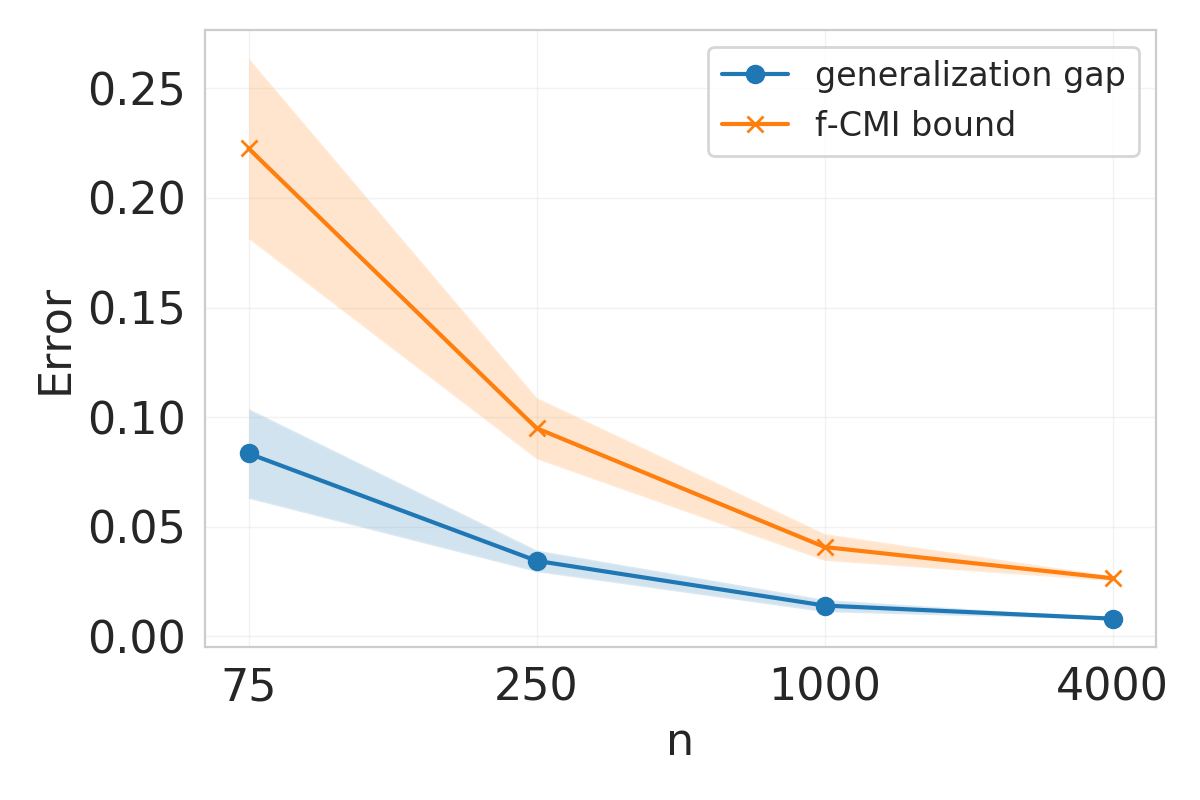

In [10]:
exp_name = "fcmi-mnist-4vs9-CNN-deterministic"
results_file_path = os.path.join(results_dir, exp_name, 'results.pkl')
with open(results_file_path, 'rb') as f:
    deterministic_results = pickle.load(f)

fig, ax = plot_over_n(deterministic_results, ns=ns, epoch=epochs[-1])
savefig(fig, os.path.join(results_dir, exp_name, f'x=n-plot.pdf'))

<IPython.core.display.Javascript object>


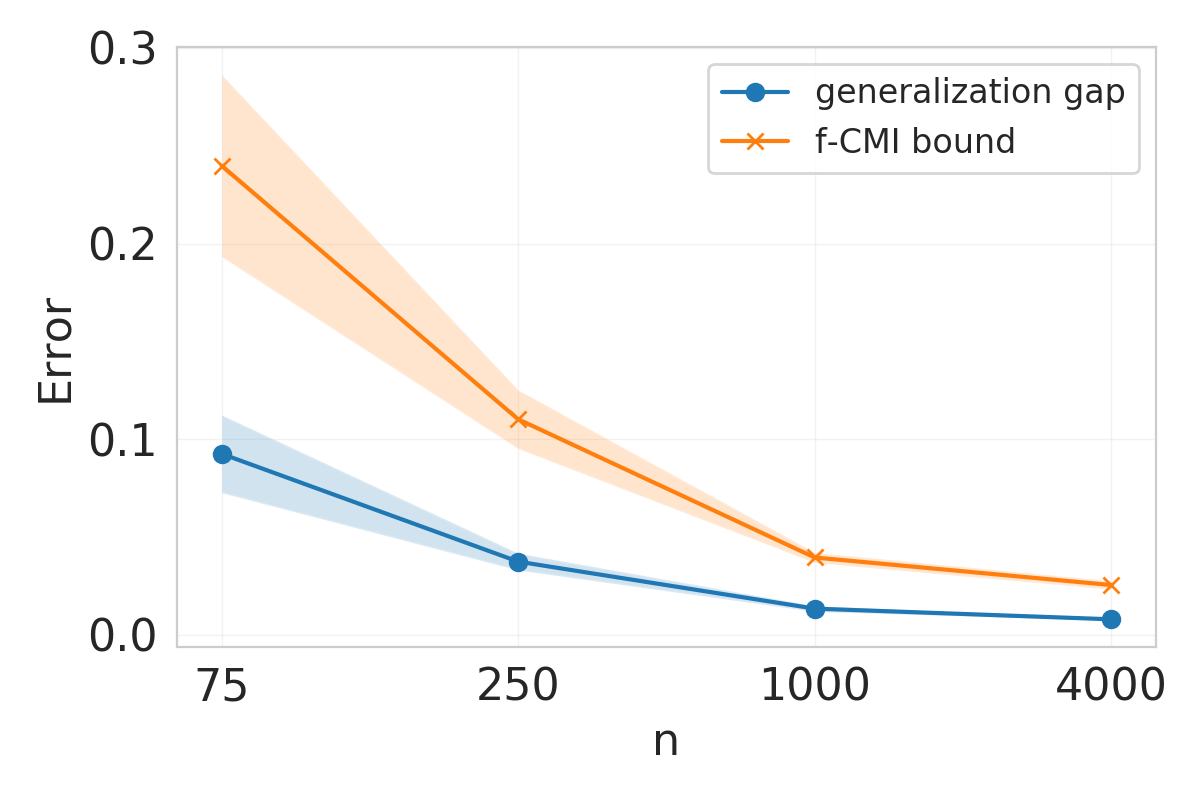

In [11]:
exp_name = "fcmi-mnist-4vs9-wide-CNN-deterministic"
results_file_path = os.path.join(results_dir, exp_name, 'results.pkl')
with open(results_file_path, 'rb') as f:
    wide_deterministic_results = pickle.load(f)

fig, ax = plot_over_n(wide_deterministic_results, ns=ns, epoch=epochs[-1])
savefig(fig, os.path.join(results_dir, exp_name, f'x=n-plot.pdf'))

<IPython.core.display.Javascript object>


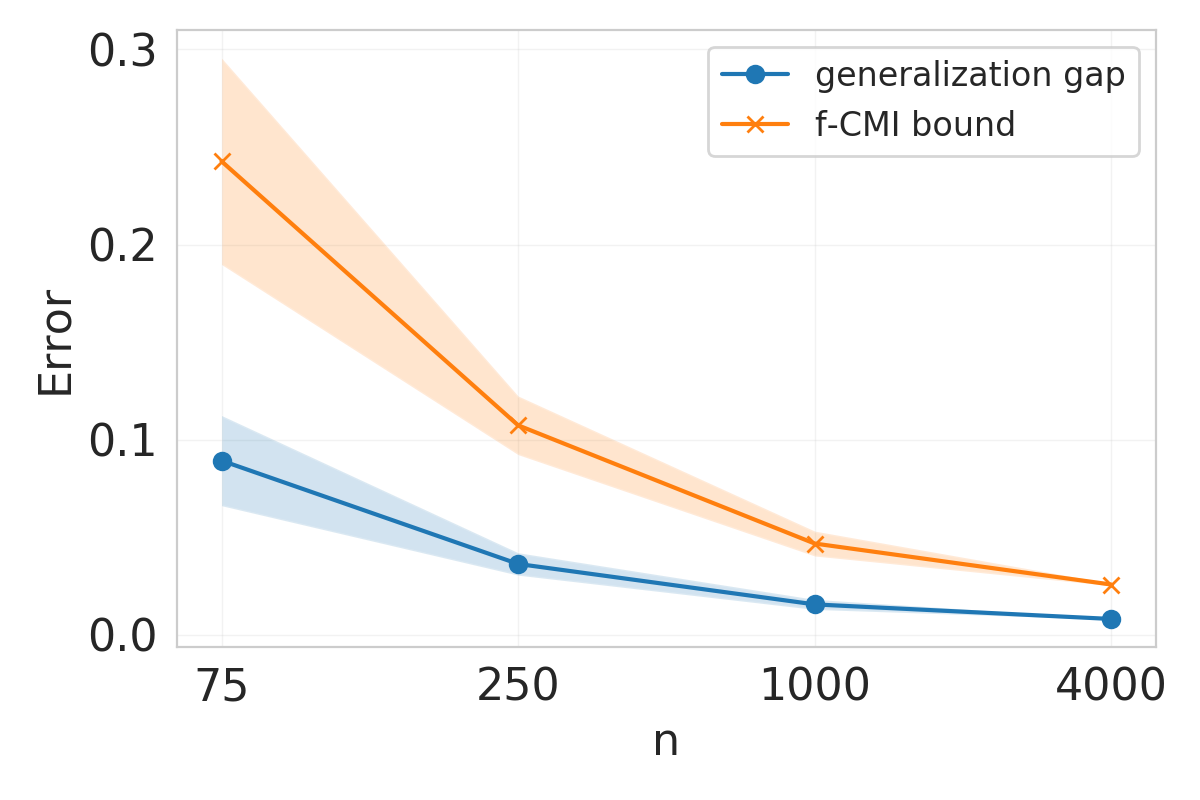

In [12]:
exp_name = "fcmi-mnist-4vs9-CNN"
results_file_path = os.path.join(results_dir, exp_name, 'results.pkl')
with open(results_file_path, 'rb') as f:
    standard_results = pickle.load(f)
    
fig, ax = plot_over_n(standard_results, ns=ns, epoch=epochs[-1])
savefig(fig, os.path.join(results_dir, exp_name, f'x=n-plot.pdf'))

<IPython.core.display.Javascript object>


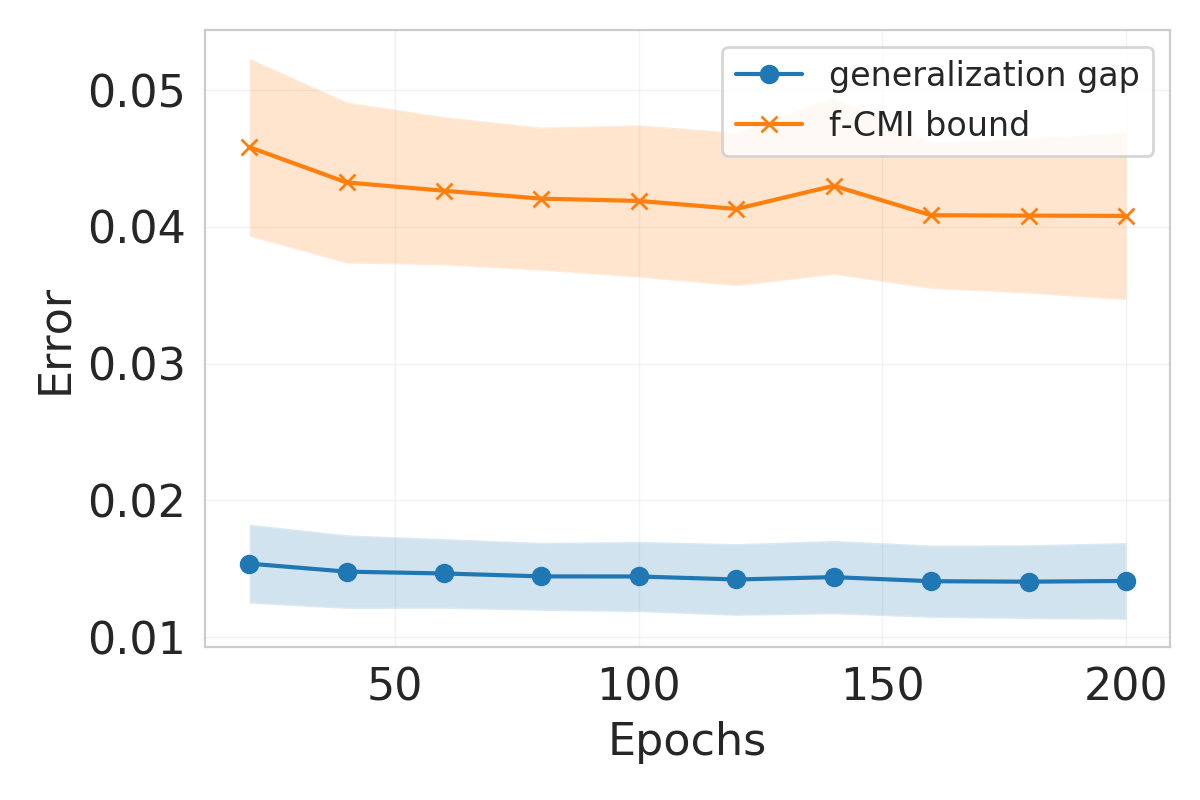

In [13]:
exp_name = "fcmi-mnist-4vs9-CNN-deterministic"
results_file_path = os.path.join(results_dir, exp_name, 'results.pkl')
with open(results_file_path, 'rb') as f:
    deterministic_results = pickle.load(f)

n=1000
fig, ax = plot_over_epochs(deterministic_results, n=n, epochs=epochs)
savefig(fig, os.path.join(results_dir, exp_name, f'n={n}-x=epoch.pdf'))

# MNIST 4 vs 9 (Langevin Dynamics)

In [9]:
results_dir = "results"
exp_name = "fcmi-mnist-4vs9-CNN-LD"
n_seeds = 5
n_S_seeds = 30
n = 4000
ns = [4000]
epochs = np.arange(1, 11) * 4
num_classes = 2
batch_size = 100

In [31]:
results_file_path = os.path.join(results_dir, f'{exp_name}', 'results.pkl')
with open(results_file_path, 'rb') as f:
    fcmi_results = pickle.load(f)
    
results_file_path = os.path.join(results_dir, f'{exp_name}', 'sgld_results.pkl')
with open(results_file_path, 'rb') as f:
    sgld_results = pickle.load(f)

In [32]:
fcmi_results[4000][8]

[{'exp_train_acc': 0.9618666,
  'exp_val_acc': 0.95505834,
  'exp_gap': 0.006808281,
  'fcmi_bound': 0.09758673933106714},
 {'exp_train_acc': 0.96118337,
  'exp_val_acc': 0.9557583,
  'exp_gap': 0.0054250956,
  'fcmi_bound': 0.0826205974824785},
 {'exp_train_acc': 0.9616167,
  'exp_val_acc': 0.9564667,
  'exp_gap': 0.00515002,
  'fcmi_bound': 0.07836105994288604},
 {'exp_train_acc': 0.96179175,
  'exp_val_acc': 0.95662504,
  'exp_gap': 0.0051667094,
  'fcmi_bound': 0.08253095993219126},
 {'exp_train_acc': 0.9606833,
  'exp_val_acc': 0.9555417,
  'exp_gap': 0.005141616,
  'fcmi_bound': 0.08382778088419757}]

<IPython.core.display.Javascript object>


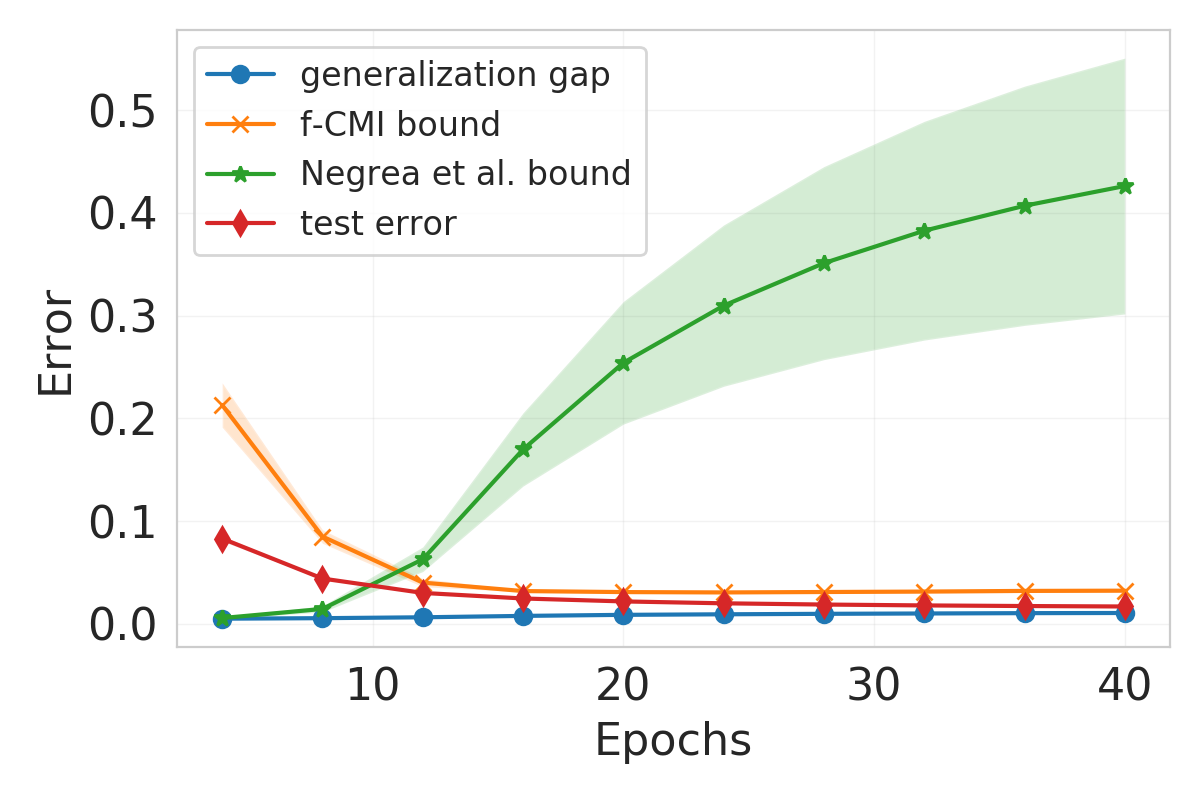

In [33]:
fig, ax = plot_over_epochs(fcmi_results, n=ns[0], epochs=epochs)

sgld_means = []
sgld_stds = []

test_means = []
test_stds = []

for epoch in epochs:
    sgld_mean = np.nanmean([d['sgld_bound'] for d in sgld_results[n][epoch]])
    sgld_std = np.nanstd([d['sgld_bound'] for d in sgld_results[n][epoch]])
    sgld_means.append(sgld_mean)
    sgld_stds.append(sgld_std)

    test_mean = 1.0 - np.nanmean([d['exp_val_acc'] for d in fcmi_results[n][epoch]])
    test_std = np.nanstd([d['exp_val_acc'] for d in fcmi_results[n][epoch]])
    test_means.append(test_mean)
    test_stds.append(test_std)
    
plot_curve(ax, epochs, sgld_means, sgld_stds, label=f'Negrea et al. bound', marker='*')
plot_curve(ax, epochs, test_means, test_stds, label='test error', marker='d')

# ax.set_yscale('log')
ax.legend()
ax.set_yticks(np.linspace(0.0, 0.5, 6))
fig.tight_layout()
savefig(fig, os.path.join(results_dir, exp_name, f'main-plot-n={n}-x=epochs.pdf'))

### understanding what happends in the beggining

for this we fix epoch = 4 and seed=0

In [10]:
with open('results/fcmi-mnist-4vs9-CNN-LD/extra_data.pkl', 'rb') as f:
    extra_data = pickle.load(f)

In [11]:
from modules.bound_utils import estimate_fcmi_bound_classification

In [12]:
fcmi_bound, list_of_mis = estimate_fcmi_bound_classification(
    masks=extra_data['masks'],
    preds=extra_data['preds'],
    num_examples=extra_data['num_examples'],
    num_classes=extra_data['num_classes'],
    return_list_of_mis=True, verbose=True)

ms: [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]
ps: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mi: 0.0
ms: [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]
ps: [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
mi: 0.04907432485493576
ms: [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
ps: [2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mi: 0.028629351023764755
ms: [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]
ps: [2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
mi: 0.05889005062470165
ms: [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
ps: [3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1,

<IPython.core.display.Javascript object>


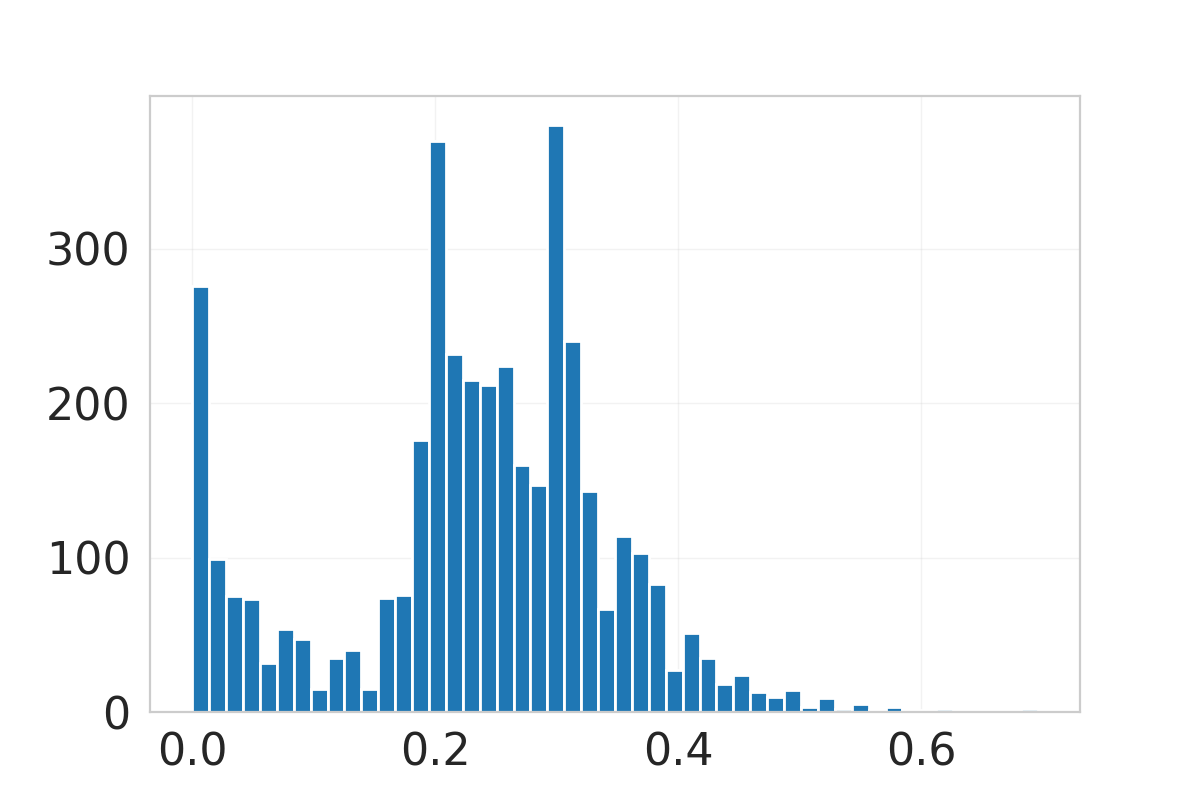

In [23]:
contributions = np.sqrt(2 * np.array(list_of_mis))
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(contributions, bins=50);

In [25]:
np.mean(contributions)

0.23221397074711417

In [14]:
from nnlib.nnlib.visualizations import plot_examples_from_dataset

<IPython.core.display.Javascript object>


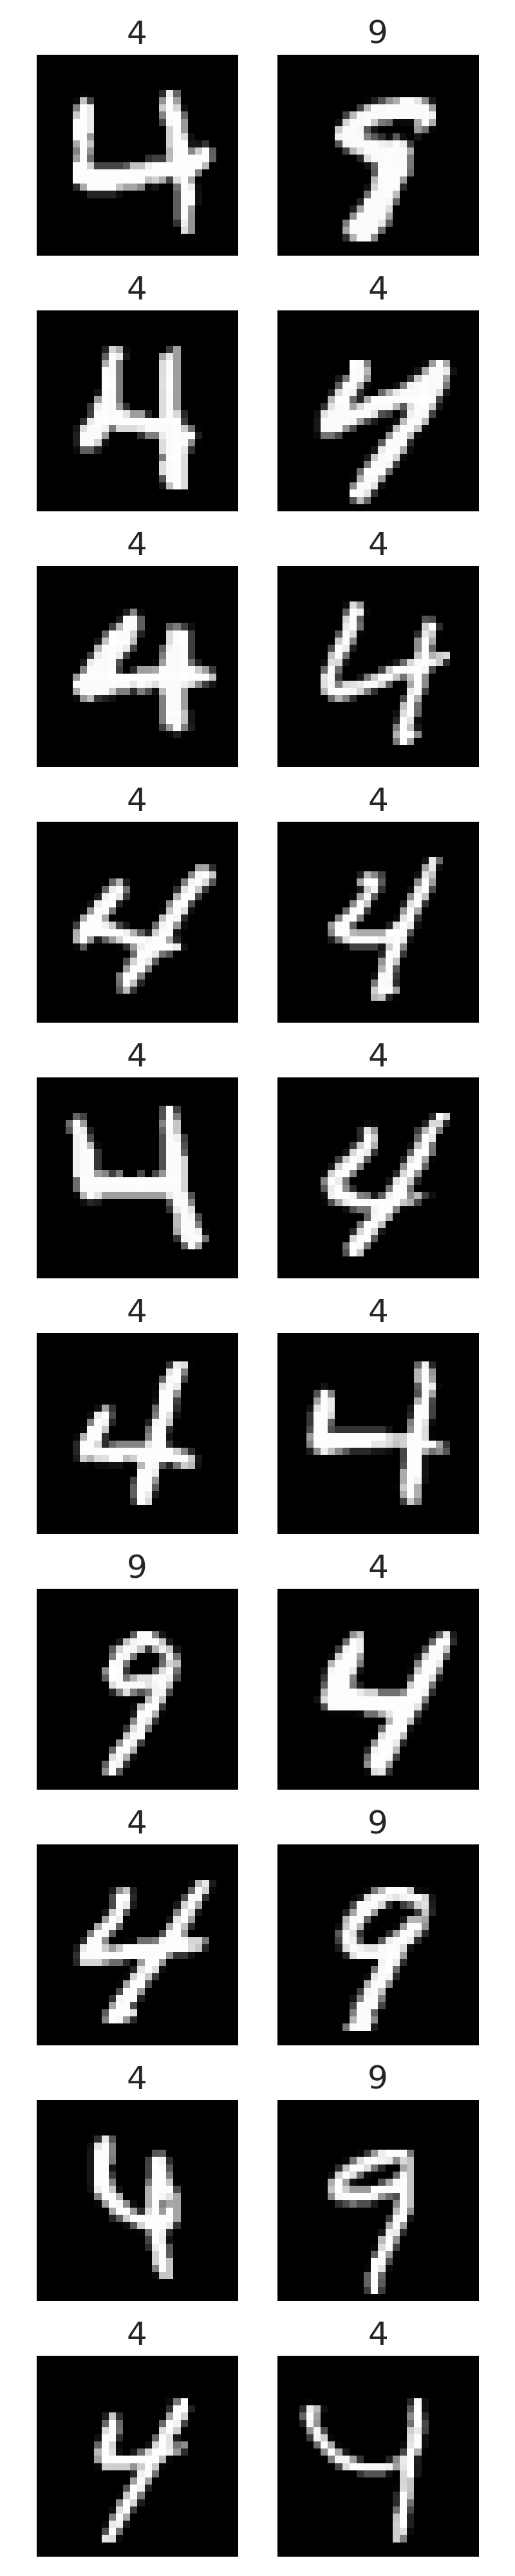

<IPython.core.display.Javascript object>


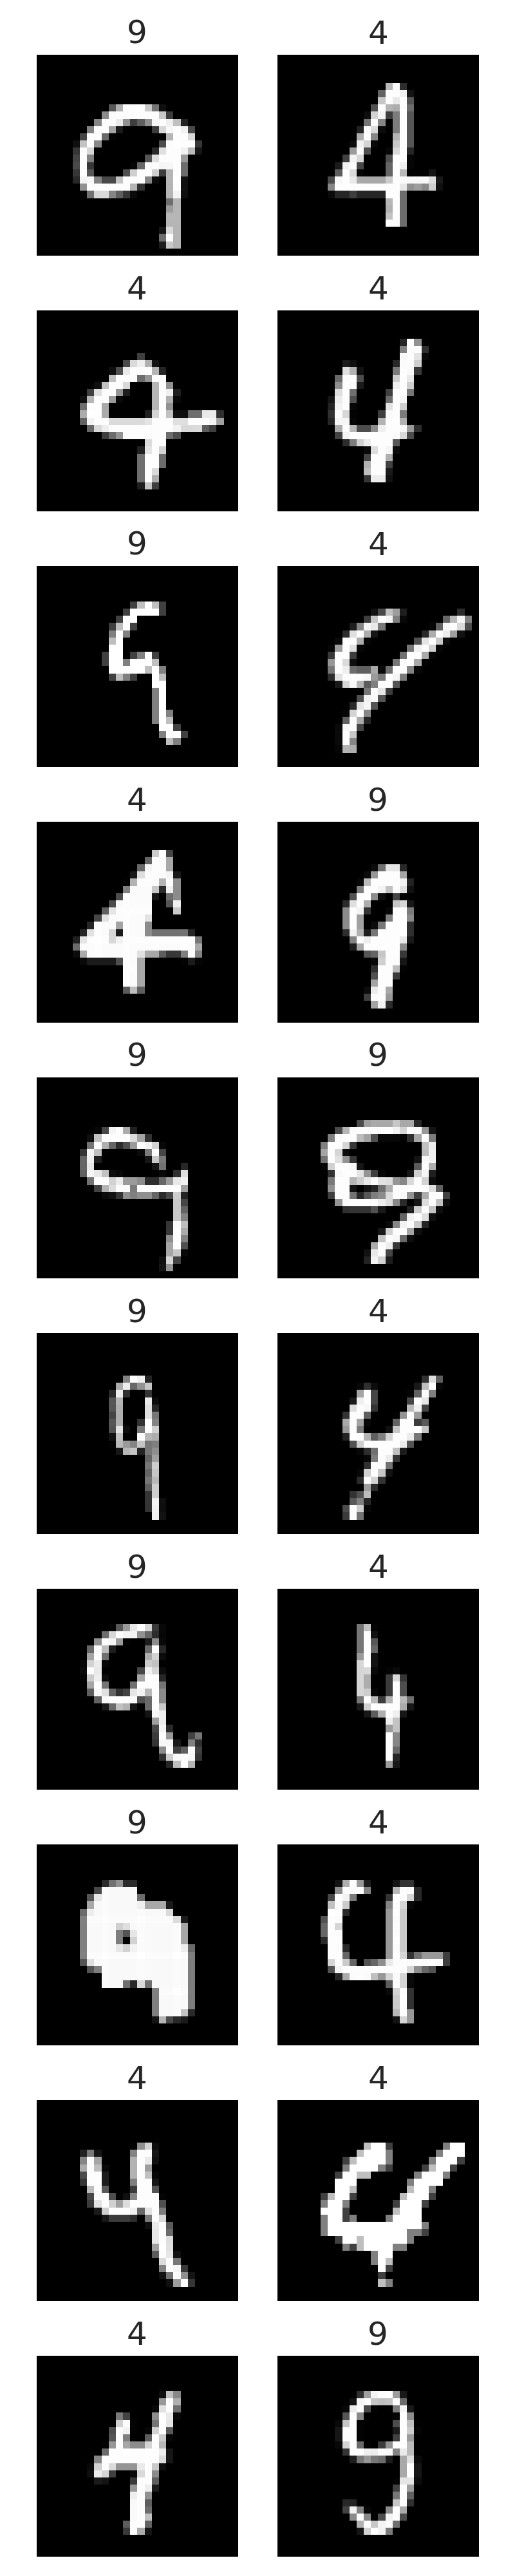

In [19]:
order = np.argsort(contributions)

def plot_pairs(all_examples, pair_indices):
    example_indices = []
    for p_idx in pair_indices:
        example_indices.extend([2*p_idx, 2*p_idx+1])
    fig, ax = plot_examples_from_dataset(data=all_examples,
                                         indices=example_indices,
                                         n_cols=2,
                                         plt=plt,
                                         label_names=['4', '9'])
    return fig, ax

plot_pairs(extra_data['all_examples'], order[:10]);
plot_pairs(extra_data['all_examples'], order[-10:]);

In [33]:
def compute_acc_for_each_example(preds, dataset):
    labels = [y for x, y in dataset]
    labels = torch.tensor(labels).long()
    acc = (preds.argmax(dim=1) == labels).float()
    return utils.to_numpy(acc)


def get_avg_train_and_val_accs_per_example(n, epoch, seed):
    accs = []
    for S_seed in range(n_S_seeds):
        dir_name = f'n={n},seed={seed},S_seed={S_seed}'
        dir_path = os.path.join(results_dir, exp_name, dir_name)
        if not os.path.exists(dir_path):
            print(f"Did not find results for {dir_name}")
            continue

        with open(os.path.join(dir_path, 'saved_data.pkl'), 'rb') as f:
            saved_data = pickle.load(f)

        model = utils.load(path=os.path.join(dir_path, 'checkpoints', f'epoch{epoch - 1}.mdl'),
                           methods=methods, device='cuda:0')

        print(list(saved_data.keys()))
        if 'all_examples_wo_data_aug' in saved_data:
            all_examples = saved_data['all_examples_wo_data_aug']
        else:
            all_examples = saved_data['all_examples']

        cur_preds = utils.apply_on_dataset(model=model, dataset=all_examples)['pred']
        cur_acc = compute_acc_for_each_example(preds=cur_preds, dataset=all_examples)
        accs.append(cur_acc)

    return np.stack(accs, axis=0) 

In [34]:
from scripts.fcmi_train_classifier import mnist_ld_schedule

accs = get_avg_train_and_val_accs_per_example(n=4000, epoch=4, seed=0)

  6%|▋         | 2/32 [00:00<00:01, 16.78it/s]

Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=0/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=1/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


100%|██████████| 32/32 [00:01<00:00, 29.00it/s]


(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=2/checkpoints/epoch3.mdl


  9%|▉         | 3/32 [00:00<00:01, 20.67it/s]

[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=3/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=4/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=5/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=6/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=7/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=8/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=9/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=10/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=11/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=12/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=13/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=14/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=15/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=16/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=17/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=18/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=19/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=20/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=21/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=22/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=23/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=24/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=25/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=26/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=27/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=28/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


  0%|          | 0/32 [00:00<?, ?it/s]

(8000,)
Loading the model from results/fcmi-mnist-4vs9-CNN-LD/n=4000,seed=0,S_seed=29/checkpoints/epoch3.mdl
[None, 1, 28, 28]
[None, 32, 14, 14]
[None, 32, 7, 7]
[None, 64, 3, 3]
[None, 256, 1, 1]
[None, 256]
[None, 128]
output.shape: [None, 2]
['args', 'mask', 'train_indices', 'val_indices', 'all_examples', 'metrics']


100%|██████████| 32/32 [00:01<00:00, 28.87it/s]


(8000,)


<IPython.core.display.Javascript object>


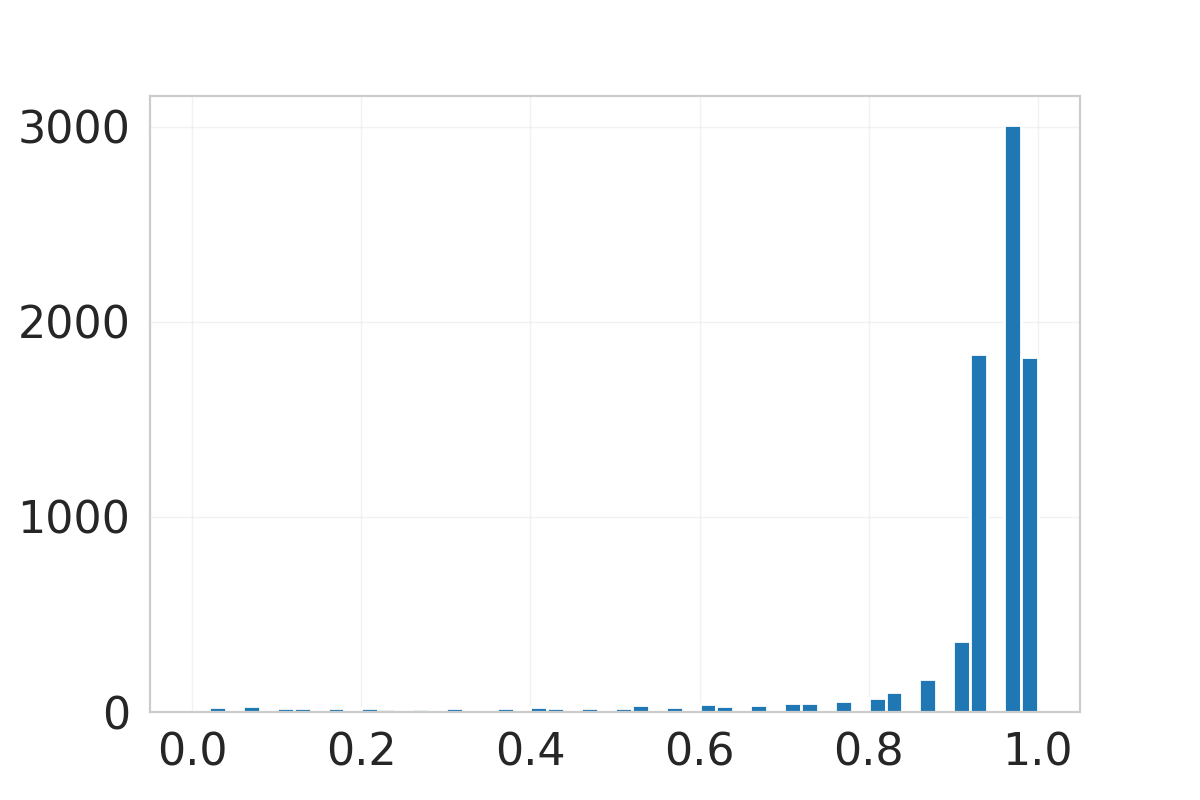

In [38]:
avg_acc_per_example = accs.mean(axis=0)

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(avg_acc_per_example, bins=50);

In [44]:
avg_accs_reshaped = avg_acc_per_example.reshape((4000, 2))

[[1.         0.15321478]
 [0.15321478 1.        ]]


<IPython.core.display.Javascript object>


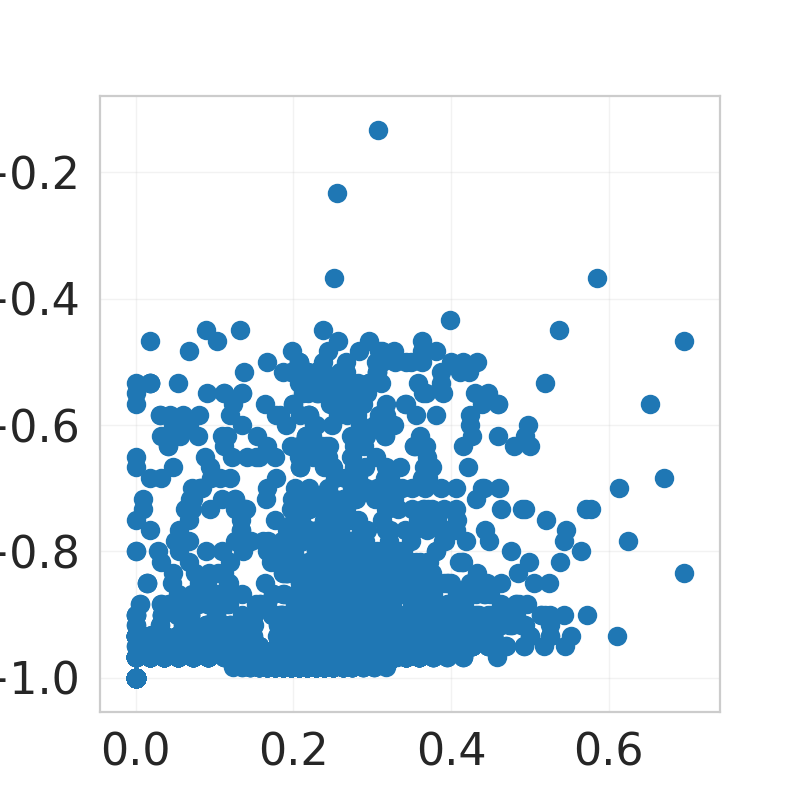

In [48]:
avg_hardness_of_pair = -avg_accs_reshaped.mean(axis=1)
print(np.corrcoef(avg_hardness_of_pair, contributions))

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(contributions, avg_hardness_of_pair)

In [46]:
max_hardness_of_pair = -avg_accs_reshaped.min(axis=1)
np.corrcoef(max_hardness_of_pair, contributions)

array([[1.        , 0.10242992],
       [0.10242992, 1.        ]])

In [47]:
diff_hardness_of_pair = np.abs(avg_accs_reshaped[:, 0] - avg_accs_reshaped[:, 1])
np.corrcoef(diff_hardness_of_pair, contributions)

array([[1.        , 0.04197091],
       [0.04197091, 1.        ]])

# Cifar-10 pretrained ResNet-50

In [41]:
results_dir = "results"
exp_name = "cifar10-pretrained-resnet50"
n_seeds = 1
n_S_seeds = 40
ns = [1000, 5000, 20000]
epochs = [40]
num_classes = 10
batch_size = 64

<IPython.core.display.Javascript object>


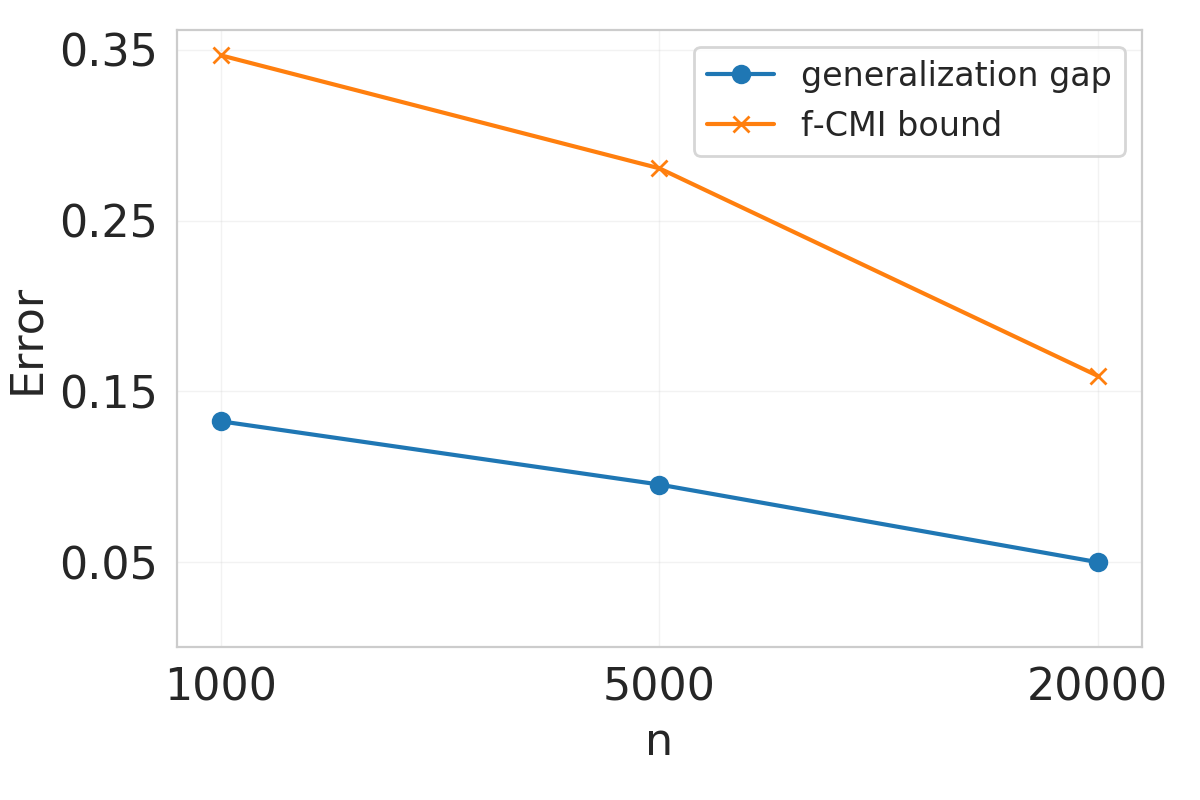

[0.13247502, 0.0954299, 0.04993701]
[0.3468594423854978, 0.28067227320152904, 0.15908099258745131]


In [42]:
results_file_path = os.path.join(results_dir, f'{exp_name}', 'results.pkl')
with open(results_file_path, 'rb') as f:
    fcmi_results = pickle.load(f)

fig, ax = plot_over_n(fcmi_results, ns=ns, epoch=epochs[-1])
ax.set_yticks(np.linspace(0.05, 0.35, 4))
ax.set_ylim(bottom=0.0)
savefig(fig, os.path.join(results_dir, exp_name, f'x=n-plot.pdf'))